In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore as zs

import datetime

In [2]:
%matplotlib inline
pd.set_option('display.max_columns',None)

#### Load Data

In [3]:
# load data
train = pd.read_pickle("train")
history_data = pd.read_pickle("hist_data_df")

#### Feature Engineering: Dates

#### Tenure = date_end - date_activ

In [4]:
train["tenure"] = ((train["date_end"] - train["date_activ"])/ np.timedelta64(1, "Y")).astype(int)

In [5]:
tenure = train[["tenure", "churn", "id"]].groupby(["tenure", "churn"])["id"].count().unstack(level=1)

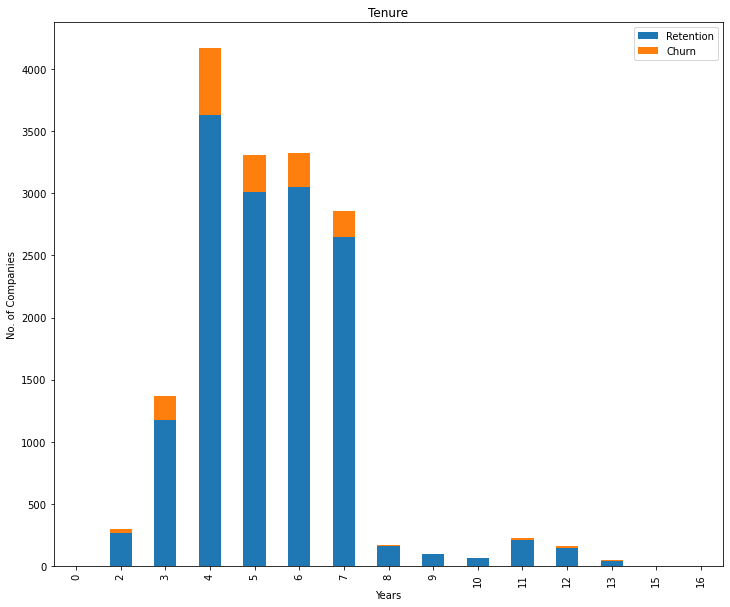

In [6]:
# creating the bar plot
tenure.plot(kind = 'bar', figsize = (12, 10), stacked = True)
plt.legend(["Retention", "Churn"], loc="upper right")
plt.xlabel("Years")
plt.ylabel("No. of Companies")
plt.title("Tenure")
plt.show()

#### mean_year_price: mean of price (year)

In [7]:
mean_year = history_data.groupby(["id"]).mean().reset_index()

In [8]:
mean_year = mean_year.rename(index=str, columns={"price_p1_var": "mean_year_price_p1_var", "price_p2_var": "mean_year_price_p2_var", 
                                                 "price_p3_var": "mean_year_price_p3_var", "price_p1_fix": "mean_year_price_p1_fix", 
                                                 "price_p2_fix": "mean_year_price_p2_fix", "price_p3_fix": "mean_year_price_p3_fix",})
mean_year["mean_year_price_p1"] = mean_year["mean_year_price_p1_var"] + mean_year["mean_year_price_p1_fix"] 
mean_year["mean_year_price_p2"] = mean_year["mean_year_price_p2_var"] + mean_year["mean_year_price_p2_fix"] 
mean_year["mean_year_price_p3"] = mean_year["mean_year_price_p3_var"] + mean_year["mean_year_price_p3_fix"]


#### convert dates to months
1. determine time delta based on a reference date
2. convert the time delta to months

In [9]:
reference = datetime.datetime(2016,1,1)
train["months_activ"] = ((reference - train["date_activ"])/np.timedelta64(1, "M")).astype(int)
train["months_end"] = -((reference - train["date_end"])/np.timedelta64(1, "M")).astype(int)
train["months_modif_prod"] = ((reference - train["date_modif_prod"])/np.timedelta64(1, "M")).astype(int)
train["months_renewal"] = ((reference - train["date_renewal"])/np.timedelta64(1, "M")).astype(int)

In [10]:
train.drop(columns=["date_activ", "date_end", "date_modif_prod", "date_renewal"], inplace=True)

#### Categorical Data: has_gas

In [11]:
train["has_gas"]=train["has_gas"].replace(["t", "f"],[1,0])

#### Categorical Data: Channel_sales

In [12]:
train_dtypes = pd.DataFrame(train.dtypes)

In [13]:
train_dtypes.index = train_dtypes.index.set_names(['Column_Name'])
train_dtypes.rename(columns = {0: "Data_Type"}, inplace=True)
train_dtypes.reset_index().sort_values(by = ['Data_Type'])

,Column_Name,Data_Type
27,months_renewal,int32
25,months_end,int32
24,months_activ,int32
23,tenure,int32
26,months_modif_prod,int32
22,churn,int64
19,num_years_antig,int64
17,nb_prod_act,int64
13,has_gas,int64
3,cons_12m,int64


In [14]:
df_string = train_dtypes[train_dtypes['Data_Type']=='object']
df_string

,Data_Type
Column_Name,
id,object
activity_new,object
channel_sales,object
origin_up,object


In [15]:
train["channel_sales"] = train["channel_sales"].fillna("null_values")

In [16]:
# Transform to categorical data type
train["channel_sales"] = train["channel_sales"].astype("category")

In [17]:
# Create the training variables by converting the string values into numerical ones using the get_dummies() method.
categories_channel = pd.get_dummies(train["channel_sales"], prefix = "channel")
categories_channel.columns = [col_name[:11] for col_name in categories_channel.columns]
categories_channel.drop(columns=["channel_nul"], inplace=True)
categories_channel.head()

,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi
0,0,0,0,0,1,0,0
1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0


#### Categorical Data: Origin_up

In [18]:
train["origin_up"] = train["origin_up"].fillna("null_values")

In [19]:
# Transform to categorical data type
train["origin_up"] = train["origin_up"].astype("category")

In [20]:
# Create the training variables by converting the string values into numerical ones using the get_dummies() method.
categories_origin_up = pd.get_dummies(train["origin_up"], prefix = "origin")
categories_origin_up.columns = [col_name[:10] for col_name in categories_origin_up.columns]
categories_origin_up.drop(columns=["origin_nul"], inplace=True)
categories_origin_up.head()

,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa
0,0,0,1,0,0
1,0,0,0,1,0
2,0,1,0,0,0
3,0,1,0,0,0
4,0,1,0,0,0


#### Categorical Data: activity_new

In [21]:
# Transform to categorical data type
train["activity_new"] = train["activity_new"].fillna("null_values")
# train["activity_new"] = train["activity_new"].astype("category")

In [22]:
categories_activity_counts = train.activity_new.value_counts()
categories_activity_counts

null_values                         9545
apdekpcbwosbxepsfxclislboipuxpop    1577
kkklcdamwfafdcfwofuscwfwadblfmce     422
kwuslieomapmswolewpobpplkaooaaew     230
fmwdwsxillemwbbwelxsampiuwwpcdcb     219
                                    ... 
iilxdefdkwudppkiekwlcexkdupeucla       1
kllldxcildwkssbmoabmsdffmawsafsf       1
wkwdccuiboaeaalcaawlwmldiwmpewma       1
ksukukiwxdxwbfwaapmuwippflemumlp       1
ewaupfkppoboxiuilledxxlwieawexel       1
Name: activity_new, Length: 420, dtype: int64

<AxesSubplot:xlabel='activity_new', ylabel='Density'>

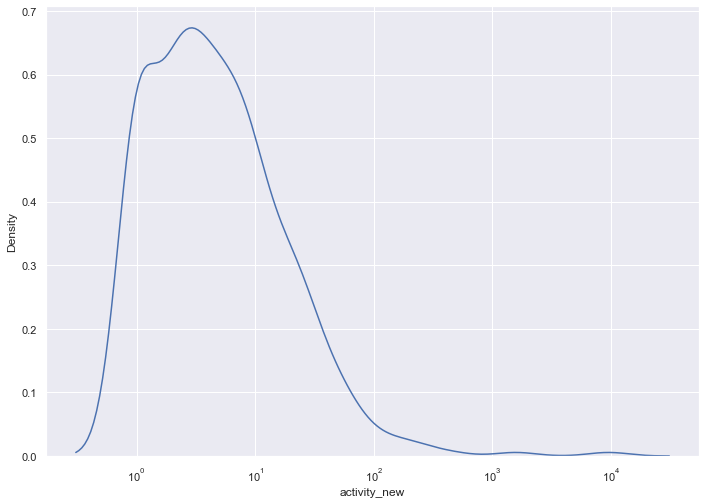

In [23]:
# Visualize the value counts of activity_new
%matplotlib inline
sns.set(rc={'figure.figsize':(11.7,8.27)})
# categories_activity_counts.plot.density()
sns.kdeplot(data=categories_activity_counts, log_scale=True)

In [24]:
# Determine which values to replace if counts are less than 500?
replace_activity = list(categories_activity_counts[categories_activity_counts <= 75].index)

# Replace in dataframe
for activity in replace_activity:
    train.activity_new = train.activity_new.replace(activity,"Other")
    
# Check to make sure binning was successful
train.activity_new.value_counts()

null_values                         9545
Other                               3471
apdekpcbwosbxepsfxclislboipuxpop    1577
kkklcdamwfafdcfwofuscwfwadblfmce     422
kwuslieomapmswolewpobpplkaooaaew     230
fmwdwsxillemwbbwelxsampiuwwpcdcb     219
ckfxocssowaeipxueikxcmaxdmcduxsa     189
cwofmuicebbcmiaaxufmfimpowpacobu     122
cluecxlameloamldmasudocsbmaoamdw     119
wxemiwkumpibllwklfbcooafckufkdlm     119
sfisfxfcocfpcmckuekokxuseixdaoeu      83
Name: activity_new, dtype: int64

In [25]:
# Create the training variables by converting the string values into numerical ones using the get_dummies() method.
categories_activity_new = pd.get_dummies(train["activity_new"], prefix = "activity")
categories_activity_new.columns = [col_name[:12] for col_name in categories_activity_new.columns]
categories_activity_new.drop(columns=["activity_nul"], inplace=True)
categories_activity_new.head()

,activity_Oth,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [26]:
# Merge one-hot encoded features to the train dataframe and drop the originals
train = pd.merge(train, categories_channel, left_index=True, right_index=True) 
train = pd.merge(train, categories_origin_up, left_index=True, right_index=True)
train = pd.merge(train, categories_activity_new, left_index=True, right_index=True)
train.drop(columns=["channel_sales", "origin_up", "activity_new"],inplace=True)

#### Log Transformation: Negative Values

In [27]:
train.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,months_activ,months_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_Oth,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,1.609600e+04,1.609600e+04,1.609600e+04,16096.000000,16096.000000,15970.000000,16096.000000,15970.000000,15970.000000,15970.000000,16096.000000,16096.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,1.948044e+05,3.191164e+04,1.946154e+04,2370.555949,1907.347229,0.991547,70.309945,0.135901,0.052951,43.533496,0.184145,196.123447,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,5.329958,58.929858,6.376615,35.741240,4.924640,0.000249,0.060015,0.000124,0.458313,0.128790,0.000746,0.089712,0.000062,0.280629,0.227634,0.486146,0.000124,0.215644,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,6.795151e+05,1.775885e+05,8.235676e+04,4035.085664,5257.364759,5.160969,79.023251,0.026252,0.048617,5.212252,0.387615,494.366979,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796,1.749248,20.125024,3.633479,30.609746,3.812127,0.015763,0.237522,0.011147,0.498275,0.334978,0.027295,0.285777,0.007882,0.449320,0.419318,0.499824,0.011147,0.411281,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,-1.252760e+05,-3.037000e+03,-9.138600e+04,-16689.260000,-85627.000000,0.000000,-242.960000,0.000000,0.000000,-0.122184,0.000000,-9038.210000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,0.000000,16.000000,-112.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.906250e+03,0.000000e+00,0.000000e+00,513.230000,0.000000,0.000000,16.230000,0.115237,0.000000,40.606701,0.000000,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,4.000000,44.000000,3.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.533250e+04,0.000000e+00,9.010000e+02,1179.160000,378.000000,0.000000,19.440000,0.142881,0.086163,44.311378,0.000000,44.465000,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,57.000000,6.000000,29.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.022150e+04,0.000000e+00,4.127000e+03,2692.077500,1994.250000,0.000000,131.470000,0.146348,0.098837,44.311378,0.000000,218.090000,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.000000,71.000000,9.000000,64.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.609711e+07,4.188440e+06,4.538720e+06,103801.930000,175375.0

In [28]:
#Remove negative values
train.loc[train.cons_12m < 0,"cons_12m"] = np.nan
train.loc[train.cons_gas_12m < 0,"cons_gas_12m"] = np.nan 
train.loc[train.cons_last_month < 0,"cons_last_month"] = np.nan 
train.loc[train.forecast_cons_12m < 0,"forecast_cons_12m"] = np.nan 
train.loc[train.forecast_cons_year < 0,"forecast_cons_year"] = np.nan 
train.loc[train.forecast_meter_rent_12m < 0,"forecast_meter_rent_12m"] = np.nan
train.loc[train.imp_cons < 0,"imp_cons"] = np.nan

In [29]:
#Apply log transformation
train["cons_12m"] = np.log10(train["cons_12m"]+1)
train["cons_gas_12m"] = np.log10(train["cons_gas_12m"]+1) 
train["cons_last_month"] = np.log10(train["cons_last_month"]+1) 
train["forecast_cons_12m"] = np.log10(train["forecast_cons_12m"]+1) 
train["forecast_cons_year"] = np.log10(train["forecast_cons_year"]+1) 
train["forecast_meter_rent_12m"] = np.log10(train["forecast_meter_rent_12m"]+1)
train["imp_cons"] = np.log10(train["imp_cons"]+1)

In [30]:
train.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_p1,forecast_price_energy_p2,forecast_price_pow_p1,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,tenure,months_activ,months_end,months_modif_prod,months_renewal,channel_epu,channel_ewp,channel_fix,channel_foo,channel_lmk,channel_sdd,channel_usi,origin_ewx,origin_kam,origin_ldk,origin_lxi,origin_usa,activity_Oth,activity_apd,activity_ckf,activity_clu,activity_cwo,activity_fmw,activity_kkk,activity_kwu,activity_sfi,activity_wxe
count,16069.000000,16090.000000,16050.000000,16055.000000,16071.000000,15970.000000,16092.000000,15970.000000,15970.000000,15970.000000,16096.000000,16069.000000,16083.000000,16083.000000,16096.000000,16081.000000,16096.000000,16093.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000,16096.000000
mean,4.283812,0.800300,2.359281,3.006826,1.869956,0.991547,1.549610,0.135901,0.052951,43.533496,0.184145,1.305021,22.462276,21.460318,1.347788,217.987028,5.030629,20.604131,0.099093,5.329958,58.929858,6.376615,35.741240,4.924640,0.000249,0.060015,0.000124,0.458313,0.128790,0.000746,0.089712,0.000062,0.280629,0.227634,0.486146,0.000124,0.215644,0.097975,0.011742,0.007393,0.007580,0.013606,0.026218,0.014289,0.005157,0.007393
std,0.915265,1.748833,1.789067,0.709778,1.612963,5.160969,0.589394,0.026252,0.048617,5.212252,0.387615,1.165532,23.700883,27.917349,1.459808,366.742030,1.676101,21.772421,0.298796,1.749248,20.125024,3.633479,30.609746,3.812127,0.015763,0.237522,0.011147,0.498275,0.334978,0.027295,0.285777,0.007882,0.449320,0.419318,0.499824,0.011147,0.411281,0.297290,0.107726,0.085668,0.086733,0.115852,0.159787,0.118684,0.071626,0.085668
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.122184,0.000000,0.000000,-525.540000,-615.660000,1.000000,-4148.990000,1.000000,1.000000,0.000000,0.000000,16.000000,-112.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.773786,0.000000,0.000000,2.713952,0.000000,0.000000,1.236285,0.115237,0.000000,40.606701,0.000000,0.000000,11.960000,11.950000,1.000000,51.970000,4.000000,12.500000,0.000000,4.000000,44.000000,3.000000,7.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.187408,0.000000,2.959041,3.073579,2.583199,0.000000,1.310481,0.142881,0.086163,44.311378,0.000000,1.662380,21.090000,20.970000,1.000000,119.680000,5.000000,13.856000,0.000000,5.000000,57.000000,6.000000,29.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.701508,0.000000,3.617000,3.430950,3.301030,0.000000,2.122126,0.146348,0.098837,44.311378,0.000000,2.341118,29.640000,29.640000,1.000000,275.810000,6.000000,19.800000,0.000000,6.000000,71.000000,9.000000,64.000000,8.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.206748,6.622052,6.656933,5.016210,5.243970,50.000000,3.382502,0.273963,0.195975,59.444710,1.000000,4.177357,374.640000,374.640000,32.000000,24570.650000,16.000000,500.000000,1.000000,16.000

#### Remove variables with high correlation

In [31]:
corr_mat = train.corr(method='pearson').abs()
  
# Convert correlation matrix to Series and sort
sorted_mat = corr_mat.unstack().sort_values()
  
sorted_mat_df = pd.DataFrame(sorted_mat)
sorted_mat_df = sorted_mat_df.rename(columns = {0:'coeff'})
sorted_mat_df.loc[(sorted_mat_df['coeff']!=1) & (sorted_mat_df['coeff']> 0.7)]

,,coeff
margin_gross_pow_ele,margin_net_pow_ele,0.766521
margin_net_pow_ele,margin_gross_pow_ele,0.766521
imp_cons,cons_last_month,0.777624
cons_last_month,imp_cons,0.777624
forecast_cons_year,cons_last_month,0.789374
cons_last_month,forecast_cons_year,0.789374
months_end,months_renewal,0.847731
months_renewal,months_end,0.847731
num_years_antig,tenure,0.931237
tenure,num_years_antig,0.931237


In [32]:
train.drop(columns=["num_years_antig", "forecast_cons_year"],inplace=True)

#### Handling Outliers: features

In [33]:
def replace_outliers(dataframe, column):
    from scipy.stats import zscore
    df = dataframe.copy(deep=True)
    df.dropna(inplace=True, subset=[column])
    
    df["zscore"] = zscore(df[column])
    mean_x = df[(df["zscore"] > -3) & (df["zscore"] < 3)][column].mean()
    dataframe[column] = dataframe[column].fillna(mean_x)
    
    return dataframe

In [35]:
features = mean_year

In [36]:
for col in features.columns:
    if col != 'id':
        features = replace_outliers(features, col)

In [37]:
features.reset_index(drop=True, inplace=True)

In [38]:
history_data.drop(columns=["price_date", "price_p1_var", "price_p2_var", "price_p3_var", "price_p1_fix", "price_p2_fix", "price_p3_fix"],inplace=True)

In [39]:
history_data = pd.merge(history_data, features, on="id")

In [ ]:
history_data.reset_index(drop=True, inplace=True)

#### Handling Outliers: train

In [40]:
def find_outliers_iqr(dataframe, column):
    
    col = sorted(dataframe[column])
    q1, q3= np.percentile(col,[25,75])
    iqr = q3 - q1
    lower_bound = q1 -(1.5 * iqr)
    upper_bound = q3 +(1.5 * iqr)
    
    results = {"iqr": iqr, "lower_bound":lower_bound, "upper_bound":upper_bound}
    return results

In [41]:
def remove_outliers_iqr(dataframe, column):
    outliers = find_outliers_iqr(dataframe, column)
    dataframe = dataframe[(dataframe[column] > outliers["lower_bound"]) & (dataframe[column] < outliers["upper_bound"])]
    
    return dataframe

In [42]:
def remove_outliers_z_score(dataframe, column):
    dataframe["zscore"] = zs(dataframe[column])
    dataframe = dataframe[(dataframe["zscore"] > -3) & (dataframe["zscore"] < 3)]
    
    return dataframe.drop(columns="zscore")

In [43]:
def replace_outliers_z_score(dataframe, column):
    df = dataframe.copy(deep=True)
    df.dropna(inplace=True, subset=[column])
    
    df["zscore"] = zs(df[column])
    mean_z = df[(df["zscore"] > -3) & (df["zscore"] < 3)][column].mean()
    dataframe[column] = dataframe[column].fillna(mean_z)
    
    return dataframe

In [44]:
train = replace_outliers_z_score(train,"cons_12m")
train = replace_outliers_z_score(train,"cons_gas_12m") 
train = replace_outliers_z_score(train,"cons_last_month")
train = replace_outliers_z_score(train,"forecast_cons_12m")
train = replace_outliers_z_score(train,"forecast_discount_energy")
train = replace_outliers_z_score(train,"forecast_meter_rent_12m")
train = replace_outliers_z_score(train,"forecast_price_energy_p1")
train = replace_outliers_z_score(train,"forecast_price_energy_p2")
train = replace_outliers_z_score(train,"forecast_price_pow_p1")
train = replace_outliers_z_score(train,"imp_cons")
train = replace_outliers_z_score(train,"margin_gross_pow_ele")
train = replace_outliers_z_score(train,"margin_net_pow_ele")
train = replace_outliers_z_score(train,"net_margin")
train = replace_outliers_z_score(train,"pow_max")
train = replace_outliers_z_score(train,"months_activ")
train = replace_outliers_z_score(train,"months_end")
train = replace_outliers_z_score(train,"months_modif_prod")
train = replace_outliers_z_score(train,"months_renewal")

In [45]:
train.reset_index(drop=True, inplace=True)

In [46]:
train.to_pickle('train')
history_data.to_pickle('hist_data_df')